In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

<h2>Example: Solow model with Cobb-Douglas production</h2>

The Solow model is a model of economic growth as a process of physical capital accumulation. By far the most common version of the Solow model assumes Cobb-Douglas functional form for intensive output:

$$ f(k) = k^{\alpha}. $$

In [3]:
def cobb_douglas_output(k, alpha, **params):
    return k**alpha

After a bit of algebra, the Solow model with Cobb-Douglas production can be reduced down to a single non-linear ordinary differential equation (ODE) and an initial condition for capital (per unit effective labor supply)...

$$ \dot{k}(t) = s k(t)^{\alpha} - (g + n + \delta) k(t),\ k(0) = k_0 $$

...the above equation says that the rate of change of the stock of physical capital (per unit effective labor supply), $\dot{k}(t)$, is the difference between the actual level of investment in physical capital, $sk(t)^{\alpha}$, and the amount of investment required to maintain the current level of physical capital, $(g + n + \delta) k(t)$.

In [4]:
def standard_solow_model(t, k, alpha, delta, g, n, s, **params):
    return [s * cobb_douglas_output(k, alpha) - (g + n + delta) * k]

def initial_condition(t, k, k0, **params):
    return [k - k0]

To complete the model we need to define some parameter values.

In [5]:
params = {'g': 0.02, 's': 0.1, 'n': 0.02, 'alpha': 0.15, 'delta': 0.04, 'k0': 1.0}

<h2>Solving the model with pyCollocation</h2>

<h3>Defining a `pycollocation.IVP` instance</h3>

In [6]:
pycollocation.problems.IVP?

In [7]:
standard_solow_ivp = pycollocation.problems.IVP(bcs_lower=initial_condition,
                                                number_bcs_lower=1,
                                                number_odes=1,
                                                params=params,
                                                rhs=standard_solow_model,
                                                )

### Finding a good initial guess for $k(t)$

Theory tells us that, starting from some initial condition $k_0$, the solution to the Solow model converges monotonically toward its long run equilibrium value $k^*$. Our initial guess for the solution should preserve this property...

In [8]:
def equilibrium_capital(alpha, delta, g, n, s, **params):
    """Equilibrium value of capital (per unit effective labor supply)."""
    return (s / (g + n + delta))**(1 / (1 - alpha))

In [9]:
def initial_mesh(basis_kwargs, num, params):
    ts = np.linspace(*basis_kwargs['domain'], num=num)
    kstar = equilibrium_capital(**params)
    ks = kstar - (kstar - params['k0']) * np.exp(-ts)
    return ts, ks

def initial_poly(basis_kwargs, num, params):
    ts, ks = initial_mesh(basis_kwargs, num, params)
    basis_func = getattr(np.polynomial, basis_kwargs['kind'])
    poly = basis_func.fit(ts, ks, basis_kwargs['degree'],
                          basis_kwargs['domain'])
    return poly
    
basis_kwargs = {'kind': 'Chebyshev', 'domain': [0, 100], 'degree': 15}
poly = initial_poly(basis_kwargs, 1000, params)
initial_coefs = poly.coef

### Solving the model

In [11]:
pycollocation.solvers.PolynomialSolver.solve?

In [12]:
nodes = pycollocation.solvers.PolynomialSolver.collocation_nodes(**basis_kwargs)

In [13]:
solution = pycollocation.solvers.PolynomialSolver.solve(basis_kwargs,
                                                        initial_coefs,
                                                        nodes,
                                                        standard_solow_ivp)


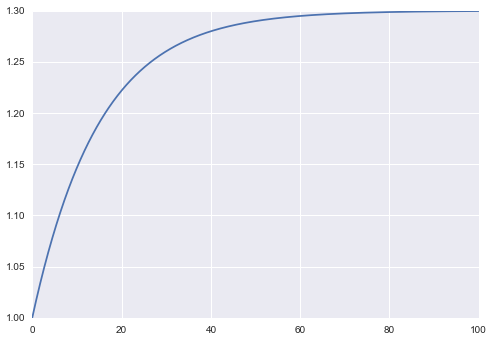

In [14]:
ts, _ = initial_mesh(basis_kwargs, 1000, standard_solow_ivp.params)
k_soln, = solution.evaluate_solution(ts)
plt.plot(ts, k_soln)
plt.show()

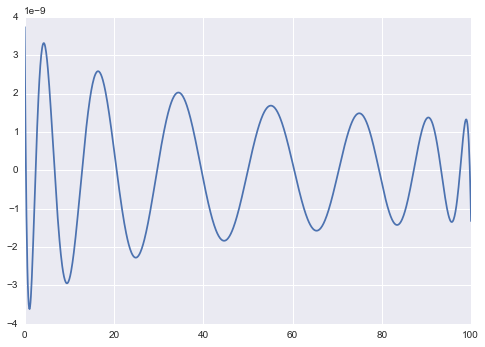

In [15]:
k_resids, = solution.evaluate_residual(ts)
plt.plot(ts, k_resids)
plt.show()

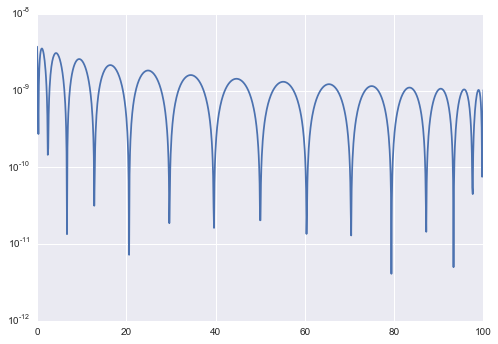

In [16]:
k_normalized_resids, = solution.normalize_residuals(ts)
plt.plot(ts, np.abs(k_normalized_resids))
plt.yscale('log')
plt.show()

<h1> Example: Generic Solow model of economic growth</h1>

Can we refactor the code above so that it can be solve a Solow model for arbitrary $f$...

$$ \dot{k}(t) = s f(k(t)) - (g + n + \delta) k(t),\ k(0) = k_0? $$

In [30]:
import functools

import numpy as np


class SolowModel(pycollocation.problems.IVP):
    """
    Class representing a generic Solow growth model.

    Attributes
    ----------
    equilibrium_capital : function
        Equilibrium value for capital (per unit effective labor).
    intensive_output : function
        Output (per unit effective labor supply).
    params : dict(str: float)
        Dictionary of model parameters.

    """

    def __init__(self, f, k_star, params):
        """
        Initialize an instance of the SolowModel class.
        
        Parameters
        ----------
        f : function
            Output (per unit effective labor supply).
        k_star : function
            Equilibrium value for capital (per unit effective labor).
        params : dict(str: float)
            Dictionary of model parameters.

        """
        rhs = self._rhs_factory(f)
        self._equilbrium_capital = k_star
        self._intensive_output = f
        super(SolowModel, self).__init__(self._initial_condition, 1, 1, params, rhs)
    
    @property
    def equilibrium_capital(self):
        return self._equilbrium_capital
    
    @property
    def intensive_output(self):
        return self._intensive_output
    
    @staticmethod
    def _initial_condition(t, k, k0, **params):
        return [k - k0]

    @classmethod
    def _solow_model(cls, t, k, f, delta, g, n, s, **params):
        return [s * f(k, **params) - (g + n + delta) * k]

    @classmethod
    def _rhs_factory(cls, f):
        return functools.partial(cls._solow_model, f=f)


class InitialPoly(object):
    """
    Class for generating initial polynomial representations of the solution
    to a Solow model of economic growth.
    
    """

    @staticmethod
    def create_mesh(basis_kwargs, num, problem):
        ts = np.linspace(*basis_kwargs['domain'], num=num)
        kstar = problem.equilibrium_capital(**problem.params)
        ks = kstar - (kstar - problem.params['k0']) * np.exp(-ts)
        return ts, ks

    @classmethod
    def fit(cls, basis_kwargs, num, problem):
        ts, ks = cls.create_mesh(basis_kwargs, num, problem)
        basis_poly = getattr(np.polynomial, basis_kwargs['kind'])
        return basis_poly.fit(ts, ks, basis_kwargs['degree'], basis_kwargs['domain'])


Example usage...

In [18]:
def ces_output(k, alpha, sigma, **params):
    rho = (sigma - 1) / sigma
    if rho == 0:
        y = cobb_douglas_output(k, alpha)
    else:
        y = (alpha * k**rho + (1 - alpha))**(1 / rho)
    return y


def ces_equilibrium_capital(g, n, s, alpha, delta, sigma, **params):
    """Steady state value for capital stock (per unit effective labor)."""
    rho = (sigma - 1) / sigma
    if rho == 0:
        kss = (s / (g + n + delta))**(1 / (1 - alpha))
    else:
        kss = ((1 - alpha) / (((g + n + delta) / s)**rho - alpha))**(1 / rho)
    return kss


ces_params = {'g': 0.02, 's': 0.1, 'n': 0.02, 'alpha': 0.15, 'delta': 0.04,
              'sigma': 0.05, 'k0': 1.0}

In [21]:
generic_solow_ivp = SolowModel(ces_output,
                               ces_equilibrium_capital,
                               ces_params)

In [31]:
basis_kwargs = {'kind': 'Chebyshev', 'domain': [0, 100], 'degree': 15}

nodes = pycollocation.solvers.PolynomialSolver.collocation_nodes(**basis_kwargs)

initial_coefs = InitialPoly.fit(basis_kwargs, 1000, generic_solow_ivp).coef

In [32]:
solution = pycollocation.solvers.PolynomialSolver.solve(basis_kwargs,
                                                        initial_coefs,
                                                        nodes,
                                                        generic_solow_ivp)


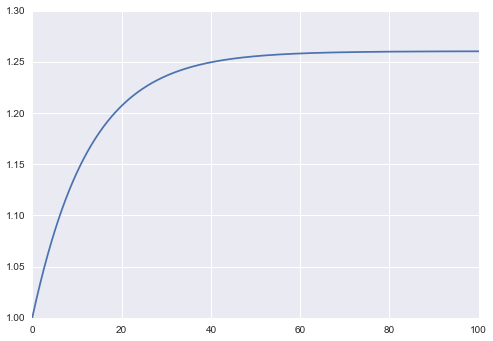

In [33]:
k_soln, = solution.evaluate_solution(ts)
plt.plot(ts, k_soln)
plt.show()

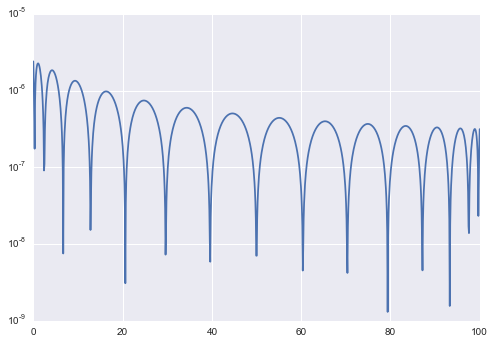

In [34]:
k_normalized_resids, = solution.normalize_residuals(ts)
plt.plot(ts, np.abs(k_normalized_resids))
plt.yscale('log')
plt.show()